EM Topic models The UCI Machine Learning dataset repository hosts several datasets recording word counts for documents here. You will use the NIPS dataset.
Cluster this to 30 topics, using a simple mixture of multinomial topic model, as lectured in class.
Produce a graph showing, for each topic, the probability with which the topic is selected.
Produce a table showing, for each topic, the 10 words with the highest probability for that topic.

In [1]:
import numpy as np
import scipy
import pandas as pd
import sklearn.cluster as sc
import matplotlib.pyplot as plt
import seaborn

In [2]:
D = 1500
W = 12419

doc_word = np.ones((D, W))

# Read doc id and word id's into a matrix
doc = open('docword.nips.txt')
lines = doc.readlines()
for line in lines[3:]:
    curr_vals = list(map(int, line.split()))
    doc_word[curr_vals[0]-1, curr_vals[1]-1] += curr_vals[2]

print("finished creating matrix")

finished creating matrix


In [3]:
#Read in vocab
vocab = []
with open('vocab.nips.txt') as f:
    for line in f:
        vocab.append(line.strip())

In [4]:
# Generate initial pi and p vectors
T = 30
w = np.zeros((D, T))
pi = np.ones(T)/T
P = np.random.random_sample((T,W))

for i in range(T):
    P[i, :] /= np.sum(P[i, :]) # Normalize

print(P)
print(pi)

[[  1.59268677e-04   1.43555511e-05   1.16404570e-04 ...,   1.14663536e-04
    7.69021927e-05   8.19818997e-05]
 [  1.35928457e-04   9.14676246e-05   6.68107293e-06 ...,   2.00133363e-05
    1.14068058e-04   2.65170915e-05]
 [  1.00555959e-04   1.03774526e-04   1.00820485e-04 ...,   7.63593037e-05
    5.53260866e-05   4.14653094e-05]
 ..., 
 [  1.22269015e-04   5.57189997e-05   8.12398931e-05 ...,   2.62514887e-05
    1.70692860e-05   1.35130184e-04]
 [  7.25674206e-05   1.54072667e-05   1.01175889e-05 ...,   1.34079125e-04
    1.55418508e-04   1.57725442e-04]
 [  8.61549147e-05   1.13682095e-04   7.87619506e-05 ...,   4.07165827e-06
    1.26024999e-04   1.41372068e-04]]
[ 0.03333333  0.03333333  0.03333333  0.03333333  0.03333333  0.03333333
  0.03333333  0.03333333  0.03333333  0.03333333  0.03333333  0.03333333
  0.03333333  0.03333333  0.03333333  0.03333333  0.03333333  0.03333333
  0.03333333  0.03333333  0.03333333  0.03333333  0.03333333  0.03333333
  0.03333333  0.03333333  0.

In [5]:
i = 0
j = 0
top = doc_word[i,:] * np.log(P[j,:])
np.sum(top)

-135874.32305143669

In [6]:
def em_step(x, w, p, pi):
    # Find the max number
    
    # For each document
    for i in range(D):
        temp = np.zeros(T)
        # For each topic
        for l in range(T):
            # Calculate new pi values
            temp[l] = np.sum(x[i,:] * np.log(p[l,:])) + np.log(pi[l])        
            max_num = np.amax(temp)
        bottom = 0
        for l in range(T):
            # Calculate denominator of w_ij
            bottom += np.exp(temp[l] - max_num)
        for j in range(T):             
            #Calculate numerator of w_ij
            top = np.sum(x[i,:] * np.log(p[j,:])) + np.log(pi[j]) - max_num
            top = np.exp(top)
            w[i,j] = top/bottom
            
    for j in range(T):
        new_p_top = np.zeros(W)
        new_p_bot = np.zeros(W)
        # For each topic, for each document, recalculate new probabilities based on the previous probabilities
        for i in range(D):
            new_p_top += x[i] * w[i,j]
            new_p_bot += np.dot(x[i], np.ones(W)) * w[i,j]
        
        p[j,:] = new_p_top/new_p_bot
        
        sum_pi = 0.0
        for i in range(D):
            sum_pi += w[i,j]
        # New average pi_j
        pi[j] = sum_pi/D

In [7]:
count = 0
while (1):
    count = count + 1
    
    old_P = np.copy(P)
    old_pi = np.copy(pi)
    
    em_step(doc_word, w, P, pi)
    
    # Check change in p and pi after EM step
    norm_P = np.linalg.norm(P-old_P)
    norm_pi = np.linalg.norm(pi-old_pi)
    
    print(count, norm_P, norm_pi)
    # Run EM until an epsilon is reached
    if norm_P < 0.0001:
        break

1 0.0444806606413 0.322950418143
2 0.00983744533351 0.153069167674
3 0.00559535679008 0.0566997171819
4 0.00389767328981 0.0329735653422
5 0.00204808186226 0.0145528852441
6 0.000945691385744 0.00649893337912
7 0.000673830428552 0.00670512328055
8 0.000660566848005 0.00583153108261
9 0.000520215320632 0.00586376901608
10 0.000421751728119 0.00269151968578
11 0.000325219361885 0.00285102227131
12 0.000355673624203 0.00298051114472
13 0.000233076525351 0.00278746558716
14 0.000289397780292 0.00329829786497
15 0.000240861088945 0.00227145199821
16 0.000272037893292 0.00117914076361
17 0.000342401641815 0.00154596850125
18 0.00016142636593 0.00119937821187
19 0.000154662219903 0.00228474346322
20 0.00013372440271 0.00173928441805
21 0.000143169673789 0.00116520562549
22 0.000124962796821 0.00089585131686
23 0.000138748608154 0.000955205401902
24 8.1981313785e-05 0.000859824108892


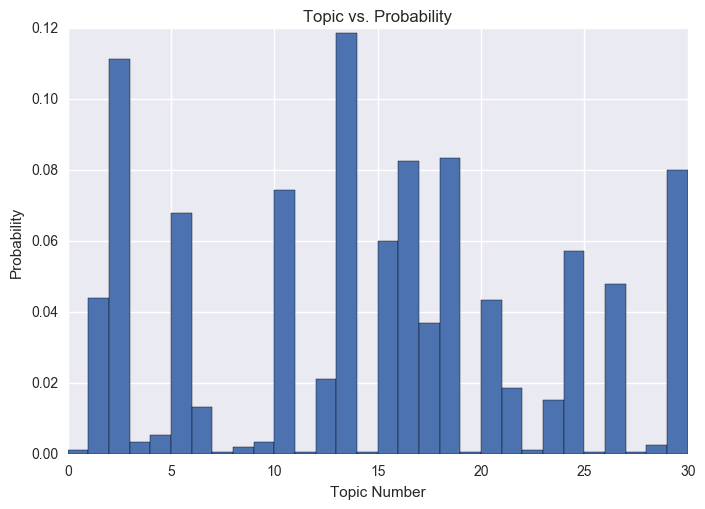

In [8]:
bar_width = 1
plt.bar(np.arange(pi.shape[0])*bar_width, pi, bar_width)
plt.title('Topic vs. Probability')
plt.xlabel('Topic Number')
plt.ylabel('Probability')
plt.show()

In [9]:
top_words = []
for t in range(T):
    # Sort words in each topic by probability
    top_ten = P[t].argsort()[-10:][::-1]
    temp_words = []
    for i in top_ten:
        # Get the top ten words
        temp_words.append(vocab[i])
    top_words.append(temp_words)


In [10]:
print(np.array(top_words))

[['model' 'nonlinear' 'data' 'control' 'process' 'mpc' 'gain' 'linear'
  'dimensional' 'function']
 ['neuron' 'model' 'input' 'synaptic' 'network' 'spike' 'cell' 'firing'
  'neural' 'pattern']
 ['network' 'unit' 'input' 'weight' 'training' 'learning' 'function'
  'output' 'set' 'error']
 ['concept' 'algorithm' 'policy' 'finite' 'vector' 'learning' 'iteration'
  'rate' 'function' 'tracker']
 ['network' 'input' 'learning' 'set' 'signature' 'space' 'neural' 'output'
  'cell' 'training']
 ['algorithm' 'function' 'set' 'network' 'problem' 'training' 'learning'
  'classifier' 'vector' 'error']
 ['network' 'input' 'learning' 'component' 'output' 'eeg' 'unit' 'system'
  'neural' 'target']
 ['object' 'view' 'unit' 'representation' 'layer' 'input' 'model' 'network'
  'rotation' 'edelman']
 ['stress' 'vowel' 'syllable' 'level' 'model' 'heavy' 'representation'
  'phonology' 'pattern' 'linguistic']
 ['routing' 'network' 'algorithm' 'learning' 'path' 'pyramid' 'node' 'load'
  'level' 'output']
 ['le

In [20]:
df = pd.DataFrame(np.asarray(top_words)).T
df[[x for x in range(12)]]

,0,1,2,3,4,5,6,7,8,9,10,11
0,model,neuron,network,concept,network,algorithm,network,object,stress,routing,learning,input
1,nonlinear,model,unit,algorithm,input,function,input,view,vowel,network,network,parameter
2,data,input,input,policy,learning,set,learning,unit,syllable,algorithm,error,neuron
3,control,synaptic,weight,finite,set,network,component,representation,level,learning,training,potassium
4,process,network,training,vector,signature,problem,output,layer,model,path,set,output
5,mpc,spike,learning,learning,space,training,eeg,input,heavy,pyramid,function,model
6,gain,cell,function,iteration,neural,learning,unit,model,representation,node,algorithm,conductance
7,linear,firing,output,rate,output,classifier,system,network,phonology,load,weight,calcium
8,dimensional,neural,set,function,cell,vector,neural,rotation,pattern,level,input,dendrite
9,function,pattern,error,tracker,training,error,target,edelman,linguistic,output,data,rate


In [21]:
df[[x for x in range(12, 24)]]

,12,13,14,15,16,17,18,19,20,21,22,23
0,model,model,program,model,network,network,network,function,learning,function,network,learning
1,system,data,allocation,data,image,input,neural,gaussian,function,network,classifier,action
2,hmm,network,memory,function,model,model,neuron,bumptrees,action,neural,input,model
3,speech,algorithm,prediction,information,object,system,system,model,algorithm,threshold,set,algorithm
4,network,function,short,cell,set,learning,input,learning,policy,input,system,robot
5,training,distribution,zorn,field,images,unit,chip,basis,control,weight,message,problem
6,recognition,set,lived,noise,input,neural,function,point,problem,number,node,environment
7,data,parameter,tree,neuron,recognition,control,circuit,mapping,system,theorem,bit,function
8,output,gaussian,lifetime,distribution,system,output,weight,constraint,model,net,neural,network
9,context,learning,decision,signal,neural,training,learning,bumptree,optimal,result,match,belief


In [24]:
df[[x for x in range(24, 30)]]

,24,25,26,27,28,29
0,network,activation,network,release,model,cell
1,model,network,word,synapse,trajectory,model
2,neural,binding,neural,spike,control,input
3,function,signature,speech,synapses,point,neuron
4,algorithm,role,system,dynamic,movement,visual
5,system,pot,training,train,arm,system
6,learning,nodes,recognition,synaptic,muscle,motion
7,problem,robin,input,parameter,inverse,network
8,matrix,evidential,set,pattern,hand,direction
9,set,node,output,neuron,minimum,unit
